In [4]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [5]:
df = pd.read_csv('data/fake_news.csv', parse_dates=['timestamp'])

(sec:fake_news_exploring)=
# Exploring the Data

The dataset of news articles we're exploring now is just one part of the larger FakeNewsNet dataset. As such, the original
research paper doesn't provide detailed information about our subset of data.
To understand the data more, we have to explore it ourselves.

Before starting exploratory data analysis, we'll apply our standard practice of splitting the data into a training and test set. We'll perform EDA using only the training set.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[['timestamp', 'baseurl', 'content']], df['label'],
    test_size=0.25, random_state=42,
)

In [7]:
# X_train is our training set
X_train.head(2)

,timestamp,baseurl,content
164,2019-01-04 19:25:46,worldnewsdailyreport.com,Chinese lunar rover finds no evidence of Ameri...
28,2016-01-12 21:02:28,occupydemocrats.com,Virginia Republican Wants Schools To Check Chi...


We can see that our training set has about 60 more articles labeled as `real` compared to `fake`:

In [8]:
y_train.value_counts()

real    320
fake    264
Name: label, dtype: int64

Our training set has 584 articles. There are only 306 non-null timestamps, as the code below shows:

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 164 to 102
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  306 non-null    datetime64[ns]
 1   baseurl    584 non-null    object        
 2   content    584 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 18.2+ KB


Next, we'll take a closer look at the `baseurl`, which represents the website that published the original article.

## Exploring the Publishers

To understand the `baseurl` column, we can start by counting the number of articles that each website published.

In [10]:
X_train['baseurl'].value_counts()

whitehouse.gov            21
abcnews.go.com            20
nytimes.com               17
                          ..
usnews.com                 1
urbanintellectuals.com     1
truetrumpers.com           1
Name: baseurl, Length: 337, dtype: int64

Our training set has 584 rows, and the code above shows that there are 337 unique publishing websites. This implies that many websites published a few articles. A histogram of the number of articles published by each website confirms this:

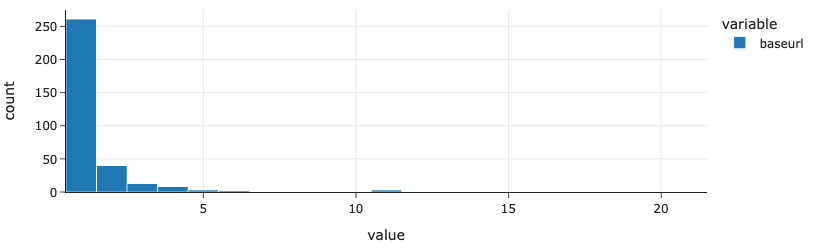

In [11]:
px.histogram(X_train['baseurl'].value_counts(), width=450, height=250)

This histogram shows that the vast majority (261 out of 337) of websites published only one article in the training set, and only a few websites published more than 5 articles total.

Nonetheless, we can still take a look at the websites that published the most fake and real articles. First, we'll start with the websites that published the most fake articles:

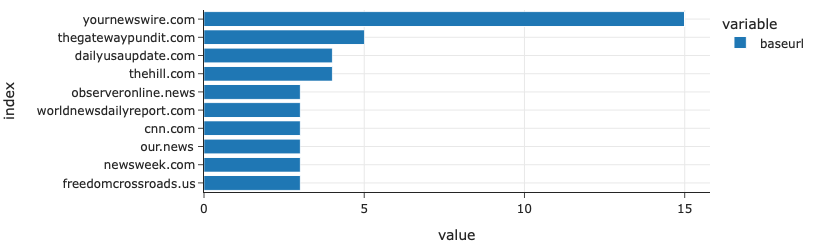

In [12]:
top_fake_publishers = (X_train
 .assign(label=y_train)
 .query('label == "fake"')
 ['baseurl']
 .value_counts()
 .iloc[:10]
 .sort_values()
)
px.bar(top_fake_publishers, orientation='h', width=550, height=250)

Next, we'll take a look at the websites that published real articles:

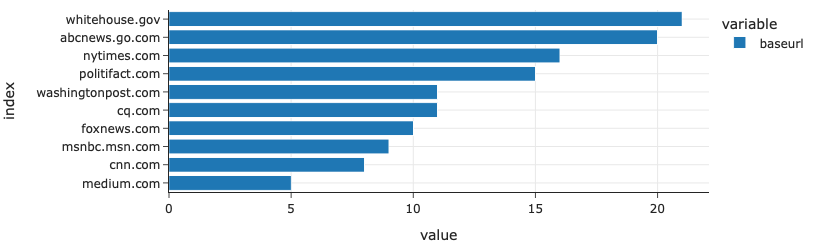

In [13]:
top_real_publishers = (X_train
 .assign(label=y_train)
 .query('label == "real"')
 ['baseurl']
 .value_counts()
 .iloc[:10]
 .sort_values()
)
px.bar(top_real_publishers, orientation='h', width=550, height=250)

Based on these bar charts, we might expect that an article from `yournewswire.com` is more likely to be labeled `fake`, while an article from `whitehouse.gov` is more likely to be labeled `real`. That said, we wouldn't expect that using the publishing website to predict article truthfulness would work very well -- there are simply too few articles published by most websites in the dataset.

Next, let's explore the `timestamp` column, which records the publish time of each news article.

## Exploring the Publish Times

Plotting the timestamps on a histogram shows that most articles were published after 2000, although there seems to be at least one article published before 1940:

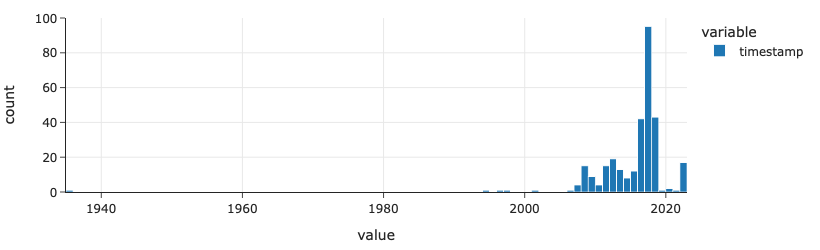

In [14]:
px.histogram(X_train['timestamp'], width=550, height=250)

Taking a closer look at the new articles published before 2000 in the dataset would show that the timestamps don't match the actual publish date of the article. These data issues are most likely related to the web scraper getting inaccurate information from the web pages, so we can zoom into the region of the histogram after 2000.

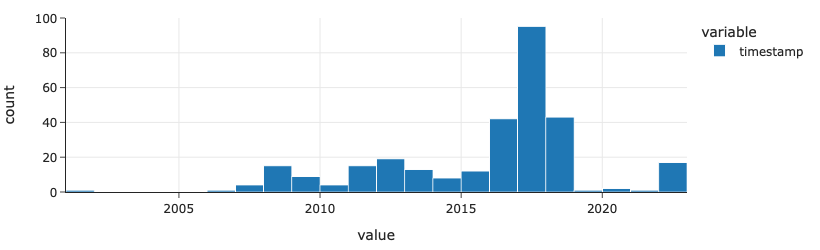

In [15]:
px.histogram(X_train.loc[X_train['timestamp'] > '2000', 'timestamp'],
             width=550, height=250)

As we expect, most articles in the dataset were published between 2007 (the year Politifact was founded) and 2020 (the year the FakeNewsNet paper was published). We also find out that the timestamps are concentrated on the years 2016-2018, the years following the controversial 2016 US Presidential Election.

## Exploring Words in Articles

We'd like to see whether there's a relationship between the words used in the articles and whether the article was labeled as `fake`. One simple way to do this is to look at individual words like `military`, then count up how many articles that mentioned `military` were labeled `fake`. We can use our domain knowledge of political topics to pick out a few candidate words to explore. Then, we define a function that creates a new feature for each word which contains `True` if the word appeared in the article and `False` if not.

In [143]:
word_features = [
    # names of presidential candidates
    'trump', 'donald', 'hillary', 'clinton',
    
    # other possibly useful words
    'military', 'state', 'vote', 'congress', 'fbi', 'shutdown',
    'investig', 'antifa', 'joke', 'princ', 'homeless', 'cnn', 'the',
]

# This function creates one new binary feature for each word in word_features,
# marking the presence of a word in an article.
def make_word_features(df, words):
    features = { word: df['content'].str.contains(word) for word in words }
    return pd.DataFrame(features)

We can use this function to calculate the number of articles that contains each word. Then, we can find the proportion of these articles that were labeled `fake`. We visualize these calculations in the plots below. In the left plot, we mark the proportion of `fake` articles in the entire training set using a dotted line, which helps us understand how informative each word feature is: a highly informative word will have a point that lies far away from the line. 

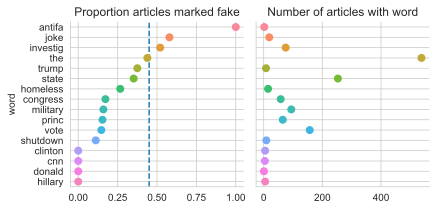

In [144]:
fake_props = (make_word_features(X_train, word_features)
 .assign(label=(y_train == 'fake'))
 .melt(id_vars=['label'], var_name='word', value_name='appeared')
 .query('appeared == True')
 .groupby('word')
 ['label']
 .agg(['mean', 'count'])
 .rename(columns={'mean': 'prop_fake'})
 .sort_values('prop_fake', ascending=False)
 .reset_index()
 .melt(id_vars='word')
)

g = sns.catplot(data=fake_props, x='value', y='word', col='variable',
                s=8, jitter=False, sharex=False, height=3)

[[prop_ax, _]] = g.axes
prop_ax.axvline(0.45, linestyle='--')
prop_ax.set(xlim=(-0.05, 1.05))

titles = ['Proportion articles marked fake', 'Number of articles with word']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set(xlabel=None)

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)

This plot reveals a few interesting considerations for modeling.
For example, notice that the word `antifa` is highly predictive---all articles that mention the word `antifa` are labeled `fake`. However, `antifa` only appears in a few articles. On the other hand, the word `the` appears in nearly every article, but is uninformative for distinguishing between `real` and `fake` articles. We might instead do better with a word like `vote`, which is both predictive and appears in many news articles.

This exploratory analysis brought us understanding of the timeframe that our news articles were published, the broad range of publishing websites captured in the data, and candidate words to use for prediction. Next, we'll fit models for predicting whether articles are fake or real.